In [ ]:
import numpy as np
import os
from time import time
import cv2

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras import utils as np_utils

class DataGenerator(Sequence):
    """Data Generator inherited from keras.utils.Sequence
    Args: 
        directory: the path of data set, and each sub-folder will be assigned to one class
        batch_size: the number of data points in each batch
        shuffle: whether to shuffle the data per epoch
    Note:
        If you want to load file with other data format, please fix the method of "load_data" as you want
    """
    def __init__(self, directory, batch_size=1, shuffle=True, data_augmentation=True):
        # Initialize the params
        self.batch_size = batch_size
        self.directory = directory
        self.shuffle = shuffle
        self.data_aug = data_augmentation
        # Load all the save_path of files, and create a dictionary that save the pair of "data:label"
        self.X_path, self.Y_dict = self.search_data() 
        # Print basic statistics information
        self.print_stats()
        return None
        
    def search_data(self):
        X_path = []
        Y_dict = {}
        # list all kinds of sub-folders
        self.dirs = sorted(os.listdir(self.directory))
        one_hots = np_utils.to_categorical(range(len(self.dirs)))
        for i,folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory,folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path,file)
                # append the each file path, and keep its label  
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
        return X_path, Y_dict
    
    def print_stats(self):
        # calculate basic information
        self.n_files = len(self.X_path)
        self.n_classes = len(self.dirs)
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
        # Output states
        print("Found {} files belonging to {} classes.".format(self.n_files,self.n_classes))
        for i,label in enumerate(self.dirs):
            print('%10s : '%(label),i)
        return None
    
    def __len__(self):
        # calculate the iterations of each epoch
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        """Get the data of each batch
        """
        # get the indexs of each batch
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # using batch_indexs to get path of current batch
        batch_path = [self.X_path[k] for k in batch_indexs]
        # get batch data
        batch_x, batch_y = self.data_generation(batch_path)
        return batch_x, batch_y

    def on_epoch_end(self):
        # shuffle the data at each end of epoch
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, batch_path):
        # load data into memory, you can change the np.load to any method you want
        batch_x = [self.load_data(x) for x in batch_path]
        batch_y = [self.Y_dict[x] for x in batch_path]
        # transfer the data format and take one-hot coding for labels
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        return batch_x, batch_y
      
    def normalize(self, data):
        mean = np.mean(data)
        std = np.std(data)
        return (data-mean) / std
    
    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(m=video, axis=2)
        return video    
    
    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval 
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and 
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])     
        # calculate numer of padded frames and fix it 
        num_pad = target_frames - len(sampled_video)
        if num_pad>0:
            padding = [video[i] for i in range(-num_pad,0)]
            sampled_video += padding     
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)
    
    def color_jitter(self,video):
        # range of s-component: 0-1
        # range of v component: 0-255
        s_jitter = np.random.uniform(-0.2,0.2)
        v_jitter = np.random.uniform(-30,30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
            s = hsv[...,1] + s_jitter
            v = hsv[...,2] + v_jitter
            s[s<0] = 0
            s[s>1] = 1
            v[v<0] = 0
            v[v>255] = 255
            hsv[...,1] = s
            hsv[...,2] = v
            video[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return video
        
    def load_data(self, path):
        data = np.load(path, mmap_mode='r')[...,:3]
        data = np.float32(data)
        # sampling 64 frames uniformly from the entire video
        data = self.uniform_sampling(video=data, target_frames=64)
        # whether to utilize the data augmentation
        if  self.data_aug:
            data = self.color_jitter(data)
            data = self.random_flip(data, prob=0.5)
        # normalize
        data = self.normalize(data)
        return data

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, LeakyReLU, Add, Multiply, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint

def scheduler(epoch):
    # Every 10 epochs, the learning rate is reduced to 1/10 of the original
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.5)
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)
model_chk = ModelCheckpoint('model1_cp/epoch-{epoch:02d}-val_acc-{val_acc:.2f}.h5', monitor='val_acc')
callbacks_list = [reduce_lr, model_chk]

In [ ]:
model = Sequential()
model.add(Input(shape=(64,224,224,3)))

model.add(Conv3D(8, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(Conv3D(8, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(Conv3D(16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(Conv3D(32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(Conv3D(64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(8,8,8)))

model.add(Conv3D(128, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(Conv3D(128, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(4,2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 64, 224, 224, 8)   224       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 224, 224, 8)   200       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 112, 112, 8)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 112, 112, 16)  1168      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 64, 112, 112, 16)  784       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 56, 56, 16)    0         
_________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [ ]:
batch_size = 2
dataset = 'D:/Khang//RWF-npy'

train_generator = DataGenerator(directory='{}/train'.format(dataset), 
                                batch_size=batch_size, 
                                data_augmentation=True)

val_generator = DataGenerator(directory='{}/val'.format(dataset),
                              batch_size=1, 
                              data_augmentation=False)

Found 1600 files belonging to 2 classes.
     Fight :  0
  NonFight :  1
Found 400 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


In [ ]:
num_epochs  = 30

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit_generator(
    generator=train_generator, 
    validation_data=val_generator,
    callbacks=callbacks_list,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator))

Epoch 1/30
800/800 [==============================] - 541s 676ms/step - loss: 0.7022 - acc: 0.5500 - val_loss: 0.6433 - val_acc: 0.6000
Epoch 2/30
800/800 [==============================] - 537s 672ms/step - loss: 0.6144 - acc: 0.6831 - val_loss: 0.5534 - val_acc: 0.7850
Epoch 3/30
800/800 [==============================] - 528s 660ms/step - loss: 0.5667 - acc: 0.7269 - val_loss: 0.4967 - val_acc: 0.7950
Epoch 4/30
800/800 [==============================] - 532s 665ms/step - loss: 0.5483 - acc: 0.7362 - val_loss: 0.4808 - val_acc: 0.7975
Epoch 5/30
800/800 [==============================] - 528s 660ms/step - loss: 0.5140 - acc: 0.7669 - val_loss: 0.4401 - val_acc: 0.8400
Epoch 6/30
800/800 [==============================] - 522s 653ms/step - loss: 0.5081 - acc: 0.7756 - val_loss: 0.5097 - val_acc: 0.8025
Epoch 7/30
800/800 [==============================] - 528s 661ms/step - loss: 0.4847 - acc: 0.7850 - val_loss: 0.4133 - val_acc: 0.8375
Epoch 8/30
800/800 [============================

In [ ]:
model.evaluate_generator(val_generator)

[0.9723671717223817, 0.8325]

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


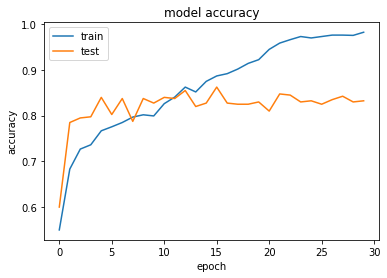

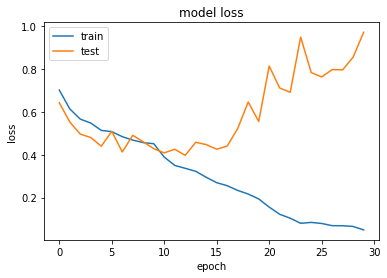

In [ ]:
import matplotlib.pyplot as plt
history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
